# Graph kernels with PASQAL processor

In [1]:
import numpy as np
from utils import jensen_shannon, return_fourier_from_dataset
from data_preprocessing import load_dataset
import pickle
import networkx as nx
import grakel
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

## Import the IMDB-MULTI dataset

We import the IMDB-MULTI dataset, limited to the graphs below 10 nodes.

Number of graphs:  814


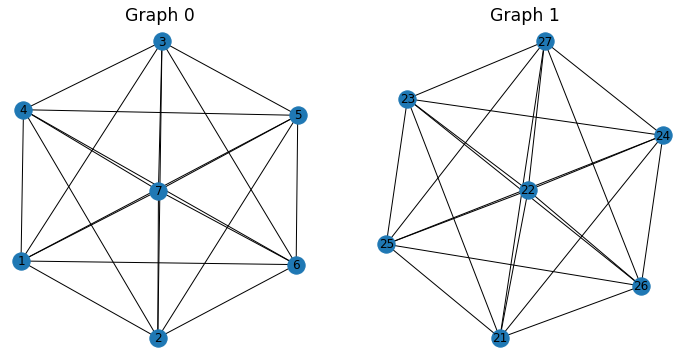

In [31]:
graphs, targets = load_dataset('IMDB-MULTI', min_node=0, max_node=10)
print("Number of graphs: ", len(graphs))

plt.figure(figsize=[12,6])
plt.subplot(121)
nx.draw(graphs[0], with_labels=True)
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
nx.draw(graphs[1], with_labels=True)
plt.title("Graph 1", fontsize='xx-large')
plt.show()

For the rest of the demo, we will limit ourselves to a sample of 20 graphs

In [34]:
np.random.seed(40)
sample = np.random.choice(len(graphs), size=20, replace=False).astype(int)

graphs_sample, targets_sample = graphs[sample], targets[sample]

## Generate the hamiltonian evolutions

Generate the fourier signals

In [35]:
#Relabel the nodes
graphs_sample = [nx.convert_node_labels_to_integers(G) for G in graphs_sample]
graphs_sample = np.array(graphs_sample, dtype=object)

#Generate signals
fourier_xy, fourier_ising = return_fourier_from_dataset(graphs_sample)

Discretize into histograms

In [36]:
histograms_xy = []
histograms_ising = []

for i in range(len(graphs_sample)):
    histograms_xy.append(np.histogram(fourier_xy[1,i], bins=500, weights=np.abs(fourier_xy[0,i])**2, density=True))
    histograms_ising.append(np.histogram(fourier_ising[1,i], bins=500, weights=np.abs(fourier_ising[0,i])**2, density=True))

Plot some histograms of XY evolution

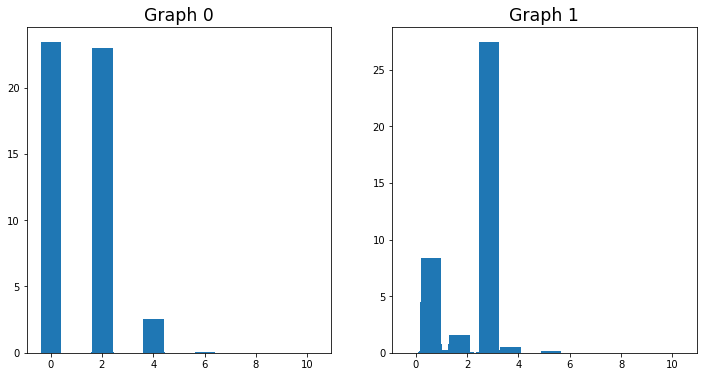

In [37]:
plt.figure(figsize=[12,6])
plt.subplot(121)
plt.bar(histograms_xy[0][1][1::], histograms_xy[0][0])
plt.title("Graph 0", fontsize='xx-large')
plt.subplot(122)
plt.bar(histograms_xy[1][1][1::], histograms_xy[1][0])
plt.title("Graph 1", fontsize='xx-large')
plt.show()

## Compute the distance matrices

In [38]:
#Initialize empty matrices
js_xy = np.zeros((len(graphs_sample), len(graphs_sample)))
js_ising = np.zeros((len(graphs_sample), len(graphs_sample)))

for i in range(len(graphs_sample)):
    for j in range(i, len(graphs_sample)):
        js_xy[i,j] = jensen_shannon(histograms_xy[i], histograms_xy[j])
        js_ising[i,j] = jensen_shannon(histograms_ising[i], histograms_ising[j])
        js_xy[j,i] = js_xy[i,j]
        js_ising[j,i] = js_ising[i,j]

## Compute the classical kernels

In [39]:
#Turn the graphs into grakel.Graph objects
graphs_grakel = [grakel.Graph(nx.adjacency_matrix(graph)) for graph in graphs_sample]

rw_kernel = grakel.RandomWalk(lamda=0.001)
gs_kernel = grakel.GraphletSampling(k=6, sampling={'n_samples':100})
lt_kernel = grakel.LovaszTheta()

K_rw = rw_kernel.fit_transform(graphs_grakel)
K_gs = gs_kernel.fit_transform(graphs_grakel)
K_lt = lt_kernel.fit_transform(graphs_grakel)

## Fit the models

In [42]:
p = 0.2
mu = 10
C = 10

#Compute the quantum kernel from the distances matrices
K_q = np.exp(-mu * (p * js_xy + (1-p) * js_ising))

#Initialize the classifier
clf = svm.SVC(kernel='precomputed', C=C, random_state=76)

#Perform a 3-fold cross-validation for every kernel
scores_q = cross_val_score(clf, K_q, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
scores_rw = cross_val_score(clf, K_rw, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
scores_gs = cross_val_score(clf, K_gs, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))
scores_lt = cross_val_score(clf, K_lt, targets_sample, cv=3, scoring=make_scorer(f1_score, average='weighted'))

print("Mean of F1 score for quantum kernel: ", np.mean(scores_q))
print("Mean of F1 score for RW kernel: ", np.mean(scores_rw))
print("Mean of F1 score for GS kernel: ", np.mean(scores_gs))
print("Mean of F1 score for LT kernel: ", np.mean(scores_lt))



Mean of F1 score for quantum kernel:  0.18820861678004538
Mean of F1 score for RW kernel:  0.20861678004535147
Mean of F1 score for GS kernel:  0.44285714285714284
Mean of F1 score for LT kernel:  0.2557823129251701
